# 1. Preprocessing

### 1) 드라이브 마운트, 데이터 불러오기, 씨드 고정

In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.metrics import *

from sklearn import preprocessing,svm,covariance

import datetime
import time

import random

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis

from sklearn.feature_selection import f_classif, SelectKBest
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier 

from sklearn.linear_model import LogisticRegression

import plotly
from plotly.offline import plot
import plotly.graph_objs as go

from collections import Counter
from sklearn.model_selection import GridSearchCV

drive.mount('/content/drive')
path = "/content/drive/My Drive/방세/data"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Random Seed 고정
def seed_everything(seed: int = 824):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
random_state = 824
seed_everything(random_state)

In [ ]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

## 2) EDA

In [ ]:
train.describe()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,...,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,magic,target
count,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,...,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000,49152.000000
mean,0.019473,0.005240,-0.042895,0.032939,0.005968,0.000677,0.030525,0.008572,-0.011887,-0.008919,-0.006987,0.007176,0.000490,-0.069342,-0.036047,-0.012719,0.036678,0.015618,0.056336,-0.005116,0.005164,-0.019016,0.008485,0.005577,0.027461,-0.021938,-0.024966,0.025235,0.035070,0.023553,0.026087,-0.035631,0.058922,-0.038533,0.032097,-0.057574,0.005810,-0.022765,-0.001920,0.008115,...,-0.018342,-0.022646,-0.014852,0.061323,0.008834,0.021663,0.000564,0.012112,-0.013887,0.011494,0.004445,0.004542,0.076560,0.023734,0.032102,0.063593,0.004936,-0.010297,-0.004504,0.010552,0.052071,0.029777,-0.047171,-0.005852,-0.022868,-0.005577,0.012045,0.013826,0.042040,-0.034065,0.016700,-0.012087,-0.001652,-0.032897,0.020619,-0.011192,-0.010633,0.016026,15.500000,0.500916
std,1.664679,1.375423,2.105449,1.780644,1.408108,1.942503,1.498615,1.497785,1.333064,1.327018,1.479408,1.370903,1.815642,1.765778,2.029365,1.854221,1.918223,2.008964,2.008778,1.804311,1.388767,1.961757,1.638133,1.664469,1.755718,1.369125,1.803115,2.023679,1.887731,1.546284,1.675253,1.797542,2.128554,2.174867,1.896807,1.903061,1.384368,1.844940,1.543977,1.717879,...,1.160643,1.696036,2.236597,1.747000,1.761635,1.973238,2.100979,1.470570,1.528988,1.669180,1.984918,1.532823,1.922399,1.788541,1.875695,2.459938,2.222647,1.990023,2.022338,1.793411,1.632597,1.883460,1.798308,1.690754,1.980943,1.550538,1.613164,1.766847,1.787150,1.759751,2.072033,1.497976,1.522331,1.504730,1.918632,2.128885,1.778711,2.128363,9.233187,0.500004
min,-17.254648,-13.037122,-15.293379,-14.824362,-16.204134,-15.057239,-18.358654,-13.054836,-17.280098,-12.718842,-13.123027,-13.286044,-17.822089,-14.160769,-14.986269,-14.124316,-15.893235,-14.129589,-14.369915,-16.201930,-13.304880,-16.737673,-13.865910,-14.048638,-15.092574,-13.789169,-15.859611,-17.580092,-14.610475,-17.427560,-14.542868,-15.933797,-15.884517,-17.390560,-17.449870,-15.951792,-14.992177,-14.620829,-15.341002,-13.012249,...,-11.402761,-20.252464,-15.247027,-14.550307,-15.270980,-16.423073,-14.709314,-13.356412,-15.765749,-13.510267,-15.994562,-14.043425,-15.582917,-15.069811,-14.176058,-16.622263,-17.427734,-15.284322,-13.651706,-13.285755,-14.722857,-14.432514,-14.288002,-13.630355,-15.686614,-14.468389,-15.615429,-14.157149,-13.800880,-14.352920,-18.893459,-12.948246,-17.814372,-14.197913,-14.451845,-13.934158,-14.451847,-14.757762,0.000000,0.000000
25%,-0.742104,-0.704664,-0.881249,-0.768942,-0.709562,-0.835916,-0.721347,-0.727164,-0.724900,-0.717791,-0.734209,-0.705783,-0.783476,-0.799365,-0.844323,-0.802297,-0.796877,-0.820848,-0.810287,-0.775459,-0.702224,-0.8

--> V0 - V254는 현재 정규화된 상태. scaling이 필요없다.

In [ ]:
# 데이터 결측치 확인하기
train.isnull().sum()

V0        0
V1        0
V2        0
V3        0
V4        0
         ..
V252      0
V253      0
V254      0
magic     0
target    0
Length: 257, dtype: int64

--> 결측치 없음

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b9ad6fa90>,
      dtype=object)

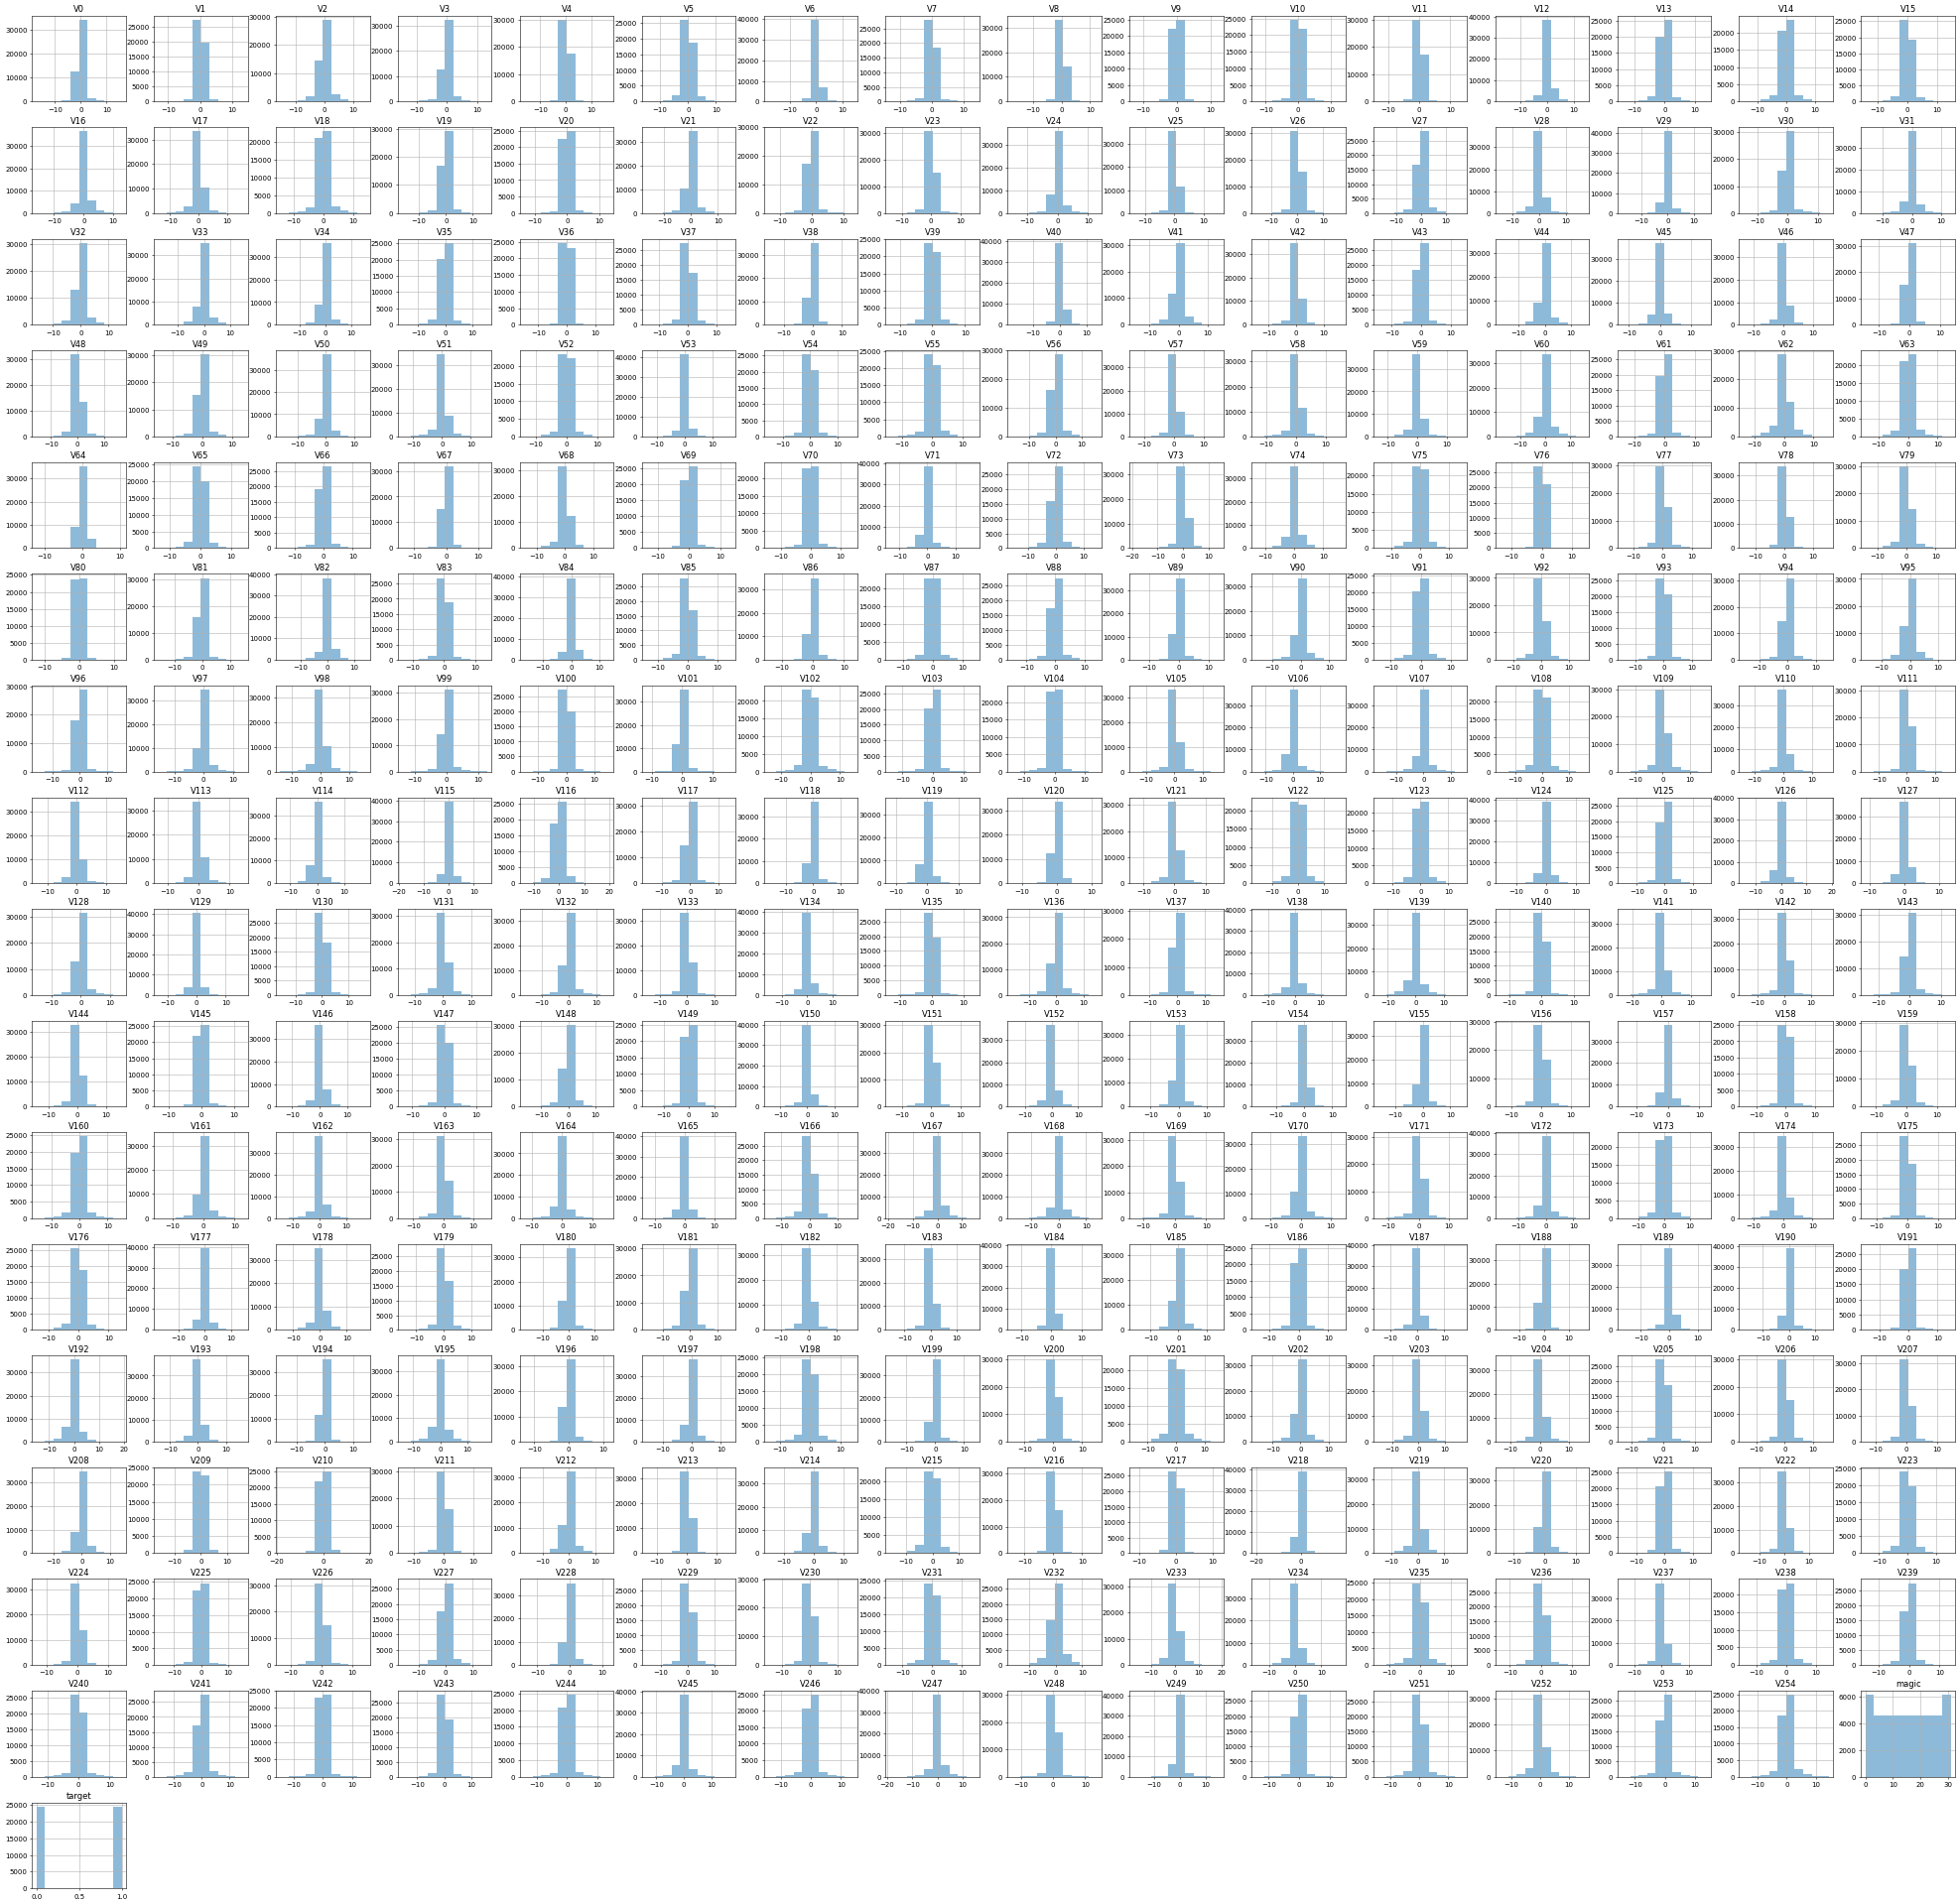

In [ ]:
# 데이터 분포 확인하기, 결과보시려면 밑으로 쭉 내려주세요!
fig, ax = plt.subplots(figsize=(50,50), dpi=50)
train.hist(ax=ax, alpha=0.5, label='x')

#### 1) magic 변수가 uniform한 분포를 띈다.
#### 2) target 변수의 분포를 보았을 때 class 불균형은 없는 것으로 판단된다. --> SMOTE 활용 X

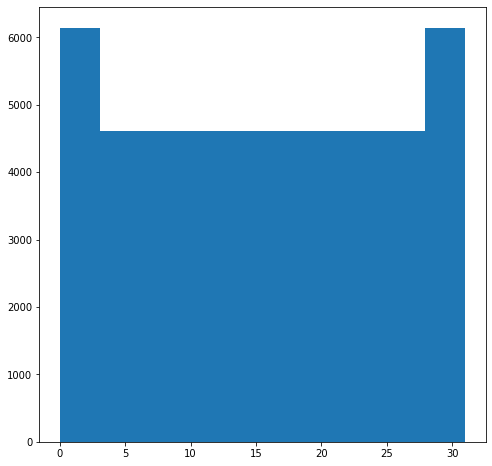

In [ ]:
# magic 변수만 uniform distribution
plt.figure(figsize=(8, 8))
plt.hist(train['magic'])
plt.show()

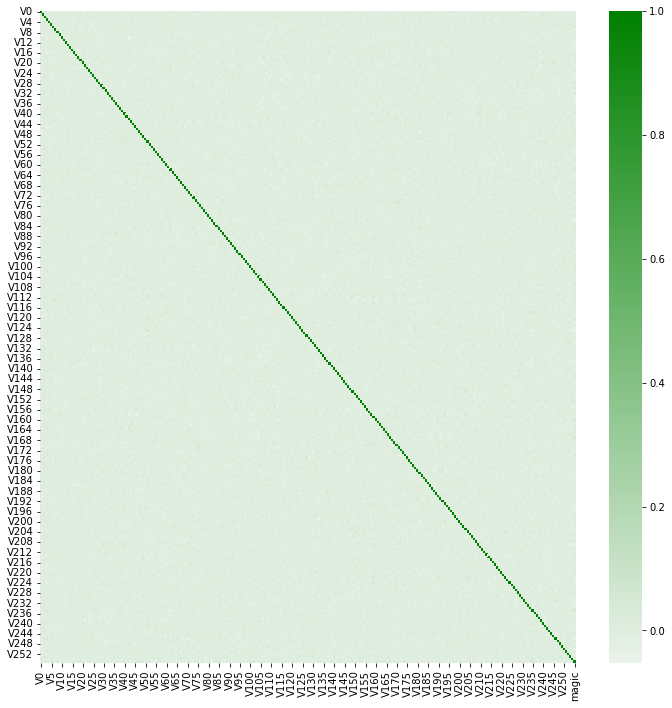

In [ ]:
# 상관분석
corr = train.iloc[:, :-1].corr(method='pearson')

plt.subplots(figsize=(12, 12))
sns.heatmap(corr, annot=False, cmap=sns.light_palette("green", as_cmap=True))

#### 1) 변수들마다 특별한 상관성을 찾지 못함 --> PCA의 사전조건을 만족하지 못했다.

### 3) 변수 선택

In [ ]:
# VIF
vif = pd.DataFrame()
vif_train=train.iloc[:,:-1]
vif["VIF Factor"] = [variance_inflation_factor(vif_train.values, i) for i in range(vif_train.shape[1])]
vif["features"] = train.iloc[:,:-1].columns
vif

,VIF Factor,features
0,1.019994,V0
1,1.014122,V1
2,1.027078,V2
3,1.018573,V3
4,1.017920,V4
...,...,...
251,1.024126,V251
252,1.025474,V252
253,1.024100,V253
254,1.027212,V254


In [ ]:
# vif가 19이 넘는 변수들 추출
vif.loc[vif["VIF Factor"]>10]

,VIF Factor,features


In [ ]:
# xgboost importance
X = train.iloc[:, :-1]
y = train['target']

model = XGBClassifier()

model.fit(X, y) 
feat_names = [i for i in range(1,257)] 

feature_importance = model.get_booster().get_score(importance_type='weight')
xgb_imp = pd.DataFrame({"feature": feature_importance.keys(),
                        "Importance": feature_importance.values()})

,feature,Importance
195,V156,1
170,V2,1
168,V108,1
194,V216,1
166,V114,1
...,...,...
27,V198,13
30,V247,13
10,V141,14
21,V66,15


In [ ]:
xgb_imp.sort_values(by="Importance", axis=0,ascending=False)

,feature,Importance
0,V223,19
21,V66,15
10,V141,14
30,V247,13
27,V198,13
...,...,...
156,V46,1
159,V59,1
160,V242,1
161,V160,1


### 4) 이상치 제거: isolated forest
--> 변수의 개수가 많아서 one class svm보다 isolated forest를 사용하는 것이 적합하다고 판단됨.

In [ ]:
feature_set=train.iloc[:,:-1]

clf=IsolationForest(n_estimators=100, contamination=float(0.005), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=824, verbose=0)

clf.fit(feature_set)
pred = clf.predict(feature_set)
feature_set['anomaly']=pred
outliers=feature_set.loc[feature_set['anomaly']==-1]
outlier_index=list(outliers.index)

print(feature_set['anomaly'].value_counts())

feature_set_1=pd.concat([feature_set,train["target"]],axis=1)

final=feature_set_1.loc[feature_set_1["anomaly"]==1].drop(["anomaly"],axis=1)

final.to_csv('/content/drive/MyDrive/방세/data/train_if.csv', index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



 1    48906
-1      246
Name: anomaly, dtype: int64


### 5) 이미지 

In [ ]:
scaler = preprocessing.MinMaxScaler()
train_scaled = scaler.fit_transform(train.iloc[:,:-1])
train_scaled = pd.DataFrame(train_scaled)

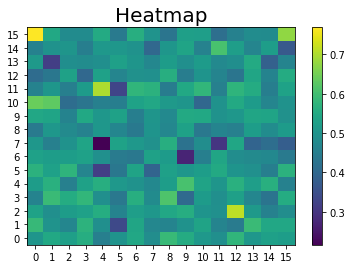

In [ ]:
# Heatmap으로 이미지 확인

a = train_scaled.iloc[0, :] # 첫번째 데이터 Heatmap 이미지
a = np.array(a)
b = np.reshape(a, (16, 16))

df = pd.DataFrame(b)

plt.pcolor(df)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.title('Heatmap', fontsize=20)
plt.colorbar()
plt.show()

### 6) 3-dimensional: magic 변수가 범주형 변수인지 확인하기 위함.

In [ ]:
data = go.Scatter3d(
    x=train.loc[:,'V141'],
    y=train.loc[:,'V66'],
    z=train.loc[:,'V223'],
    text = ['Label: #{}'.format(train['target'][i]) for i in range(train.shape[0])],
    mode='markers',
    marker=dict(
        size=3,
        color=train['magic'],
        colorscale='Jet',
        showscale=True,
        line=dict(
            width=0.0
        ),
        opacity=0.8
    )
)

In [ ]:
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    margin=go.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:410: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




In [ ]:
fig = go.Figure(data=[data], layout=layout)

plot(fig, filename='Magic.html', auto_open=True)

'Magic.html'

#### 결론: magic를 범주형 변수라고 가정을 두고 분석을 진행하겠다. 

# 2. Modeling

In [30]:
# 이상치 제거된 데이터 불러오기
data = pd.read_csv("train_if.csv")
test = pd.read_csv("test.csv")
train, valid = train_test_split(train, test_size=0.2, random_state=824, shuffle=True)
submission=pd.read_csv("/content/drive/My Drive/방세/제출양식/submission.csv")

In [31]:
params = {
    'nu': [np.random.uniform(0.01, 0.1) for q in range(8)],
    'coef0': [np.random.uniform(0.05, 0.75) for q in range(8)]
}

valid_ac = []
valid_auc = []

target = []
predict = []

In [32]:
time_list_training=[]
time_list_predict=[]

from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV

train_org = pd.read_csv("train_if.csv")
test = pd.read_csv("test.csv")
train, valid = train_test_split(train_org, test_size=0.2, random_state=824, shuffle=True)

params = {
    'nu': [np.random.uniform(0.01, 0.1) for q in range(10)],
    'coef0': [np.random.uniform(0.05, 0.75) for q in range(10)]
}

valid_ac = []
valid_auc = []

target = []
predict = []

for i in range(32):
    select_SKB = SelectKBest(f_classif, k='all')

    X_total = np.array(train_org[train_org['magic'] == i].drop(['target', 'magic'], axis=1))
    y_total = np.array(train_org[train_org['magic'] == i]['target'])

    X_train = train[train['magic'] == i].drop(['target', 'magic'], axis=1)
    y_train = train[train['magic'] == i]['target']

    X_valid = valid[valid['magic'] == i].drop(['target', 'magic'], axis=1)
    y_valid = valid[valid['magic'] == i]['target']

    X_test=test[test['magic'] == i].drop(['magic'], axis=1)
    X_test_index=test.index[test['magic'] == i].tolist()

    X_train_SKB = select_SKB.fit_transform(X_train, y_train)
    X_valid_SKB = select_SKB.transform(X_valid)
    X_test_SKB=select_SKB.transform(X_test)

    # SMOTE
    print("SMOTE 전 레이블 분포: ", Counter(y_train))
    smote = SMOTE(random_state=0)
    X_train_SKB, y_train = smote.fit_resample(X_train_SKB, y_train)
    print("SMOTE 후 레이블 분포: ", Counter(y_train))

    # Grid Search
    model_base = svm.NuSVC(kernel='poly', degree=4, shrinking=True, random_state=825)
    model_tuning = GridSearchCV(estimator=model_base,
                            param_grid=params,
                            scoring='roc_auc',
                            cv=5,
                            verbose=0)
    model_tuning.fit(X_train_SKB, y_train)
    print("Best Param: ", model_tuning.best_estimator_)
    final_param = model_tuning.best_params_

    # 모델 학습
    model = model_tuning.best_estimator_
    y1_pred = model.predict(X_train_SKB)
    y2_pred = model.predict(X_valid_SKB)

    # test case 학습시키고 predict값 순서에 맞게끔 배치 
    fin_model = model_tuning.best_estimator_
    start = time.time()
    fin_model.fit(X_total, y_total)
    time_list_training.append((time.time() - start))

    start = time.time()
    y_pred = fin_model.predict(X_test_SKB)
    time_list_predict.append((time.time() - start))
    submission['target'][X_test_index] = y_pred

    target.extend(list(y_valid))
    predict.extend(list(y2_pred))

    print("Magic == %d | Train Accuracy = %f | Valid Accuracy = %f\n" % (i, np.mean(y1_pred == y_train), np.mean(y2_pred == y_valid)))
    valid_ac.append(np.mean(y2_pred == y_valid))
    valid_auc.append(roc_auc_score(y2_pred, y_valid))

SMOTE 전 레이블 분포:  Counter({1: 622, 0: 615})
SMOTE 후 레이블 분포:  Counter({1: 622, 0: 622})
Best Param:  NuSVC(coef0=0.06634416982660787, degree=4, kernel='poly',
      nu=0.02627071301561259, random_state=825)
Magic == 0 | Train Accuracy = 1.000000 | Valid Accuracy = 0.911263

SMOTE 전 레이블 분포:  Counter({0: 609, 1: 602})
SMOTE 후 레이블 분포:  Counter({1: 609, 0: 609})
Best Param:  NuSVC(coef0=0.06634416982660787, degree=4, kernel='poly',
      nu=0.09537394336989118, random_state=825)
Magic == 1 | Train Accuracy = 1.000000 | Valid Accuracy = 0.946844

SMOTE 전 레이블 분포:  Counter({0: 624, 1: 606})
SMOTE 후 레이블 분포:  Counter({1: 624, 0: 624})
Best Param:  NuSVC(coef0=0.06634416982660787, degree=4, kernel='poly',
      nu=0.03248806245587559, random_state=825)
Magic == 2 | Train Accuracy = 1.000000 | Valid Accuracy = 0.912162

SMOTE 전 레이블 분포:  Counter({1: 614, 0: 601})
SMOTE 후 레이블 분포:  Counter({0: 614, 1: 614})
Best Param:  NuSVC(coef0=0.06634416982660787, degree=4, kernel='poly',
      nu=0.0802376193935

In [33]:
print("training time: "+str(np.sum(time_list_training)))
print("predict time: "+str(np.sum(time_list_predict)))

training time: 11.354127883911133
predict time: 2.9393978118896484


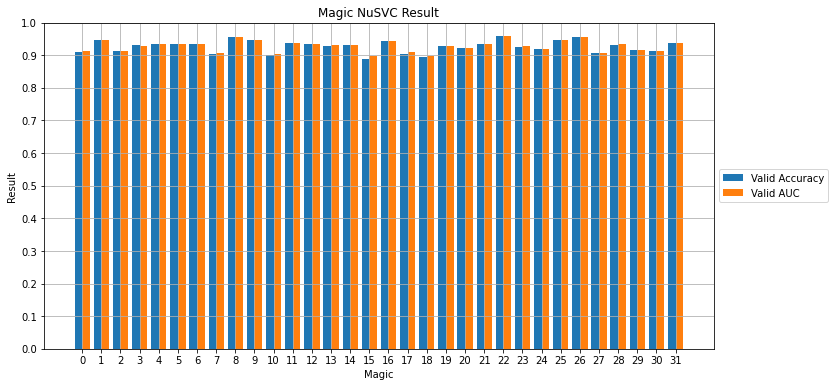

In [34]:
# 범주별 결과

index = np.arange(len(valid_ac))

plt.figure(figsize=(12, 6))
plt.title("Magic NuSVC Result")
bar_width=0.4
plt.grid(True)
plt.bar(index-0.5*bar_width, valid_ac, bar_width, label='Valid Accuracy')
plt.bar(index+0.5*bar_width, valid_auc, bar_width, label="Valid AUC")
plt.xticks(index, index)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylim(0, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Magic")
plt.ylabel("Result")

plt.show()

In [35]:
# Confusion Matrix

import itertools
from sklearn.metrics import *
from sklearn.metrics import roc_auc_score

def conf_matrix(predicted, yt, model_name):
    Y_pred = predicted 

    pred = pd.DataFrame(Y_pred, columns = ["RESULT"])
    pred['RESULT'] = pred['RESULT'].apply(lambda x: 1 if x >= 0.5 else 0)

    y_pred = np.array(pred)
    plt.figure(figsize=(4,4)) 
    cm = confusion_matrix(yt, y_pred) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - %s" % (model_name))
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    thresh = cm.max()/1.2
    normalize = False
    fmt = '.2f' if normalize else 'd'
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i,j] > thresh else "black", 
                 fontsize=12)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()
    print(classification_report(yt, y_pred))
    print("AUC: ", roc_auc_score(Y_pred, yt))

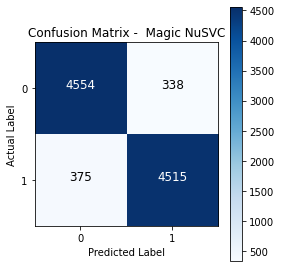

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4892
           1       0.93      0.92      0.93      4890

    accuracy                           0.93      9782
   macro avg       0.93      0.93      0.93      9782
weighted avg       0.93      0.93      0.93      9782

AUC:  0.927136009262707


In [36]:
conf_matrix(predict, target, " Magic NuSVC")

# 3. Prediction

In [37]:
# 제출용 파일 만들기
print("AUC: ", roc_auc_score(target, predict))
print("\nConfusion Matrix: \n", confusion_matrix(target, predict))
submission.to_csv('submission_final.csv', index=False)

AUC:  0.9271102438437112

Confusion Matrix: 
 [[4554  338]
 [ 375 4515]]
